# Importing Dependencies

### Instance Segmentation of Powder Particles and Satellites

This example is used to generate a visualization of an individual image


In [1]:
## regular module imports
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import skimage.io
import sys

## detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.structures import BoxMode
#from detectron2.evaluation import coco_evaluation
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation.coco_evaluation import instances_to_coco_json
from detectron2.utils.visualizer import GenericMask
import pycocotools.mask as mask_util
from skimage import measure
from imantics import Polygons, Mask




## Setting System Path

In [2]:
## ampis
root = '../../../'
sys.path.append(root)
from ampis import data_utils, visualize, export_anno

In [3]:
EXPERIMENT_NAME = 'satellite' # can be 'particles' or 'satellite'
cfg = get_cfg() # initialize cfg object
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))  # load default parameters for Mask R-CNN
cfg.MODEL.DEVICE='cuda'  # 'cpu' to force model to run on cpu, 'cuda' if you have a compatible gpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Since we are training separate models for particles and satellites there is only one class output
cfg.TEST.DETECTIONS_PER_IMAGE = 400 if EXPERIMENT_NAME == 'particle' else 150  # maximum number of instances that can be detected in an image (this is fixed in mask r-cnn)
                        # Increasing this may improve the training results, but will take longer to run (especially without a gpu!) 

## Establishing model Weights

In [4]:
# model weights will be downloaded if they are not present
cfg.OUTPUT_DIR = str(Path(f'{EXPERIMENT_NAME}_output_img_transformation'))
# make the output directory
os.makedirs(Path(cfg.OUTPUT_DIR), exist_ok=True)
model_checkpoints = sorted(Path(root, 'models', 'satellite_output_auto_W3.4').glob('*.pth'))  # paths to weights saved druing training
#cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # predictor requires this field to not be empty
cfg.MODEL.WEIGHTS = str(model_checkpoints[-1])  # use the last model checkpoint saved during training. If you want to see the performance of other checkpoints you can select a different index from model_checkpoints.
predictor = DefaultPredictor(cfg)  # create predictor object

### Importing image, converting to polygon, and exporting detections


In [31]:
'''
def flip_save_image(name, horizontally, vertically, save=True):
    new_name = name
    img_path = Path('Auto_annotate_images', image_name +'.png')
    img = cv2.imread(str(img_path))
    if horizontally:
        new_name += 'x'
        img = cv2.flip(img, 1)
    if vertically:
        new_name += 'y'
        img = cv2.flip(img, 0)
    new_img_path = Path('Auto_annotate_images', new_name +'.png')
    if save:
        cv2.imwrite(str(new_img_path), img)
    return new_name

def invert_list(input_list, list_range):
    output_list = []
    for i in input_list:
        output_list.append(i)
    for i in range(len(output_list)):
        output_list[i] = list_range - output_list[i]
    return output_list



def invert_shape(input_dict, img_width, img_height, horizontal, vertical):
    if horizontal: 
        input_dict['shape_attributes']['all_points_x'] = invert_list(input_dict['shape_attributes']['all_points_x'], img_width)
    if vertical: 
        input_dict['shape_attributes']['all_points_y'] = invert_list(input_dict['shape_attributes']['all_points_y'], img_height)
    return input_dict


def invert_x_y_regions(input_list, img_width, img_height, horizontal, vertical):
    output_list = []
    for i in input_list:
        output_list.append(invert_shape(i, img_width, img_height, horizontal, vertical))
    return output_list
'''
###TODO: Finish up this method. The name of the image must be changed, including the additional image size
###Then these methods must be created for both horizontal and verticle shifts
###Create an automated program to create all of the neccesary images and test http://www.learningaboutelectronics.com/Articles/How-to-flip-an-image-horizontally-vertically-in-Python-OpenCV.php#:~:text=To%20horizontally%20flip%20an%20image,1%20(for%20horizontal%20flipping).
###Import new docs into VIA and see how they look
def flip_and_save(name, horizontally, vertically, save=True):
    new_name = name
    img_path = Path(root, '..', 'SEM_Images', 'initial_paper_complete_set', name +'.png')
    img = cv2.imread(str(img_path))
    if horizontally:
        new_name += 'X'
        img = cv2.flip(img, 1)
    if vertically:
        new_name += 'Y'
        img = cv2.flip(img, 0)
    new_img_path = Path(root, '..', 'SEM_Images', 'initial_paper_complete_set', 'geometric', new_name +'.png')
    if save:
        cv2.imwrite(str(new_img_path), img)
    return new_name
print('')

def color_and_save(name, transformation):
    #transformation: 0-1 = darker, 1 = no change, 1+ = lighter
    im = Image.open(root + '../SEM_Images/initial_paper_complete_set/geometric/' + name + '.png')
    enhancer = ImageEnhance.Brightness(im)
    factor = transformation
    im_output = enhancer.enhance(factor)
    name_change = name
    if factor < 1:
        name_change += 'd'
    elif factor > 1: 
        name_change += 'b'
    else:
        name_change += 's'
    im_output.save(root + '../SEM_Images/initial_paper_complete_set/photometric/' + name_change + '.png')

    

In [5]:
image_name = "S02_02_SE1_500X19"
img_path = Path('Auto_annotate_images', image_name +'.png')
image_size = os.path.getsize(img_path)
print(image_size)
import PIL
image = PIL.Image.open(img_path)
width, height = image.size
print(width, height)

FileNotFoundError: [Errno 2] No such file or directory: 'Auto_annotate_images/S02_02_SE1_500X19.png'

In [ ]:
files = os.listdir(root +  '../SEM_Images/initial_paper_complete_set')
img_names = []
for f in files:
    if f.split('.')[0] != 'geometric':
        img_names.append(f.split('.')[0])
        

        
#flip_and_save(img_names[0], True, True, save=True)
for f in img_names:
    if f != '':
        print("transforming: " + f)
        flip_and_save(f, True, True, save=True)
        flip_and_save(f, False, True,save=True )
        flip_and_save(f, True, False, save=True)
        flip_and_save(f, False, False, save=True) 

In [34]:
files = os.listdir(root +  '../SEM_Images/initial_paper_complete_set/geometric')
img_names = []
for f in files:
    if f.split('.')[0] != 'geometric' and f.split('.')[0] != 'photometric':
        img_names.append(f.split('.')[0])
        
from PIL import ImageEnhance, Image
        
#flip_and_save(img_names[0], True, True, save=True)
for f in img_names:
    if f != '':
        print("transforming: " + f)
        color_and_save(f, 0.75)
        color_and_save(f, 1)
        color_and_save(f, 1.5)

transforming: S06_03_SE1_500X75X
transforming: S08_01_SE1_1000X94X
transforming: S06_03_SE1_500X75
transforming: HP743_10S_500xX
transforming: S04_03_SE1_1000X53
transforming: S02_01_SE1_500X15X
transforming: S07_03_SE1_1000X91
transforming: S04_01_SE1_1000X45X
transforming: HP743_12S_500x
transforming: S02_03_SE1_300X22XY
transforming: S04_01_SE1_1000X45
transforming: HP743_5S_500xXY
transforming: HP743_11S_500xY
transforming: HP743_5S_500xY
transforming: S02_02_SE1_1000X20
transforming: S02_01_SE1_500X15Y
transforming: S02_02_SE1_1000X20X
transforming: S03_01_SE1_1250X28Y
transforming: S06_02_SE1_500X71X
transforming: HP743_9S_500x
transforming: S02_02_SE1_300X18X
transforming: S03_02_SE1_1250X35
transforming: HP743_6S_250xY
transforming: HP743_7S_500xY
transforming: HP743_4S_500xXY
transforming: S02_03_SE1_500X23
transforming: S04_03_SE1_1000X53X
transforming: S05_01_SE1_300X56
transforming: HP743_1S_500xY
transforming: S05_01_SE1_300X56XY
transforming: HP743_3S_500x
transforming: S

In [9]:
'''def invert_x_y_via(input_dict, horizontal, vertical, width, height):
    inverted_dict = {}
    modifier = ''
    if horizontal:
        modifier += 'x'
    if vertical:
        modifier += 'y'
    print(modifier)
    for i in input_dict:
        split_name = i.split('.png')
        flip_save_image(split_name[0], horizontal, vertical)
        size = os.path.getsize('Auto_annotate_images/' + split_name[0] + modifier + '.png')
        input_dict[i]['filename'] = split_name[0] + modifier + '.png'
        input_dict[i]['size'] = size
        input_dict[i]['regions'] = invert_x_y_regions(input_dict[i]['regions'], width, height, horizontal, vertical)
        inverted_dict[split_name[0]+modifier+'.png'+str(size)] = input_dict[i]
    return inverted_dict
'''  
    
img = cv2.imread(str(img_path))
outs = predictor(img)
export1 = export_anno.make_VIA_file(image_name +'.png', img_path, outs)
inverted_export_XY = export_anno.invert_x_y_via(export1, True, True, 1024, 768)
for i in inverted_export_XY:
    title = i.split('.')[0]
    export_anno.save_to_json('Auto_annotate_images/annotations/'+title+'_anno.json', inverted_export_XY)
outs = predictor(img)
export1 = export_anno.make_VIA_file(image_name +'.png', img_path, outs)
inverted_export_X = export_anno.invert_x_y_via(export1, True, False, 1024, 768)
for i in inverted_export_X:
    title = i.split('.')[0]
    export_anno.save_to_json('Auto_annotate_images/annotations/'+title+'_anno.json', inverted_export_X)
outs = predictor(img)
export1 = export_anno.make_VIA_file(image_name +'.png', img_path, outs)
inverted_export_Y = export_anno.invert_x_y_via(export1, False, True, 1024, 768)
for i in inverted_export_Y:
    title = i.split('.')[0]
    export_anno.save_to_json('Auto_annotate_images/annotations/'+title+'_anno.json', inverted_export_Y)

xy
x
y


### Visualizing detections


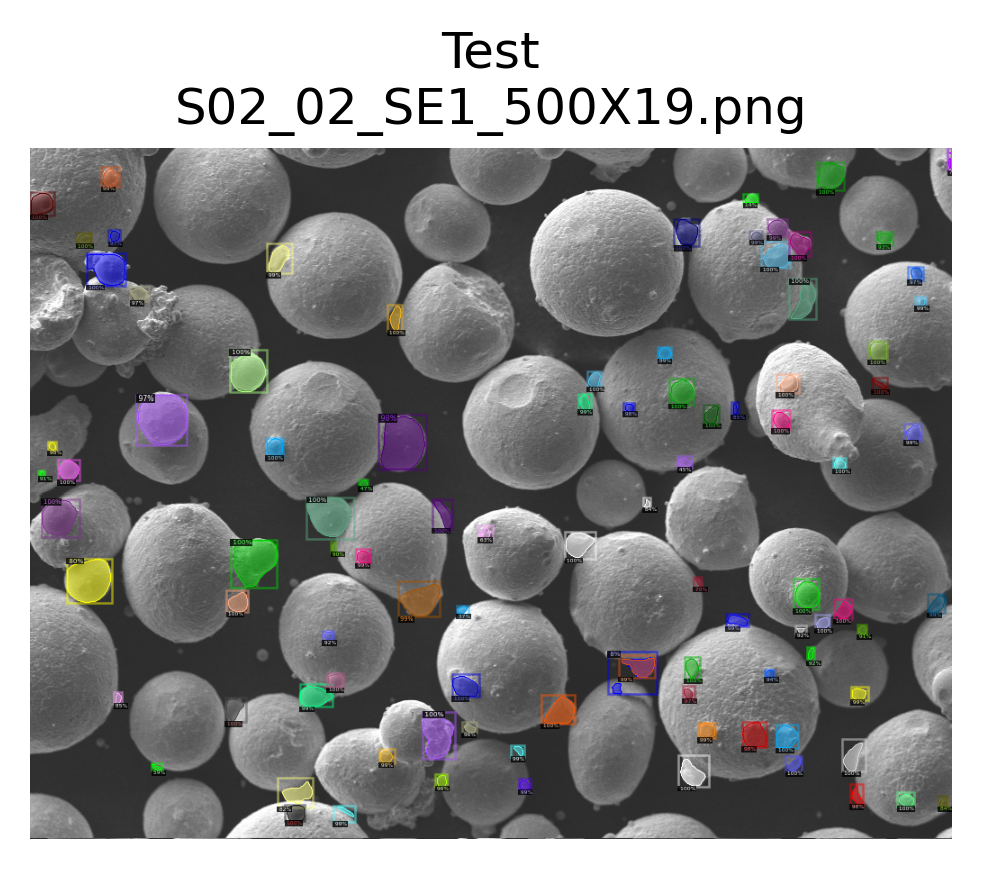

In [32]:
outs = predictor(img)
data_utils.format_outputs(img_path, dataset='test', pred=outs)
visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save fi$
                                 gt=False,  # specifies format as model predict$
                                 img_path=img_path, # path to image
                                 suppress_labels=True, #hides class images
                                 summary=False)  #hides the end print statement